# Financial News - Preprocessing for word2vec

See notebook [lda_financial_news](../15_topic_modeling/07_financial_news/lda_financial_news.ipynb) for download instructions.

## Imports

In [1]:
import os, tarfile, sys, json
from pathlib import Path
from time import time
from pprint import pprint
from collections import Counter

import numpy as np
from numpy.random import choice
import pandas as pd
import seaborn as sns

import spacy
from spacy.lang.en import English

from gensim.models.word2vec import LineSentence
from gensim.models.phrases import Phrases, Phraser

### Settings

In [2]:
pd.set_option('float_format', '{:,.2f}'.format)
sns.set_style('whitegrid')
np.random.seed(42)

In [3]:
LANGUAGES = ['en', 'es']
language_dict = dict(zip(LANGUAGES, ['English', 'Spanish']))

In [4]:
def format_time(t):
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return '{:02.0f}:{:02.0f}:{:02.0f}'.format(h, m, s)

In [5]:
stop_words = set(pd.read_csv('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words',
                             header=None,
                             squeeze=True).tolist())

In [6]:
data_path = Path('data', 'fin_news')
if not data_path.exists():
    data_path.mkdir(exist_ok=True)
article_path = data_path / 'articles.txt'
clean_article_path = data_path / 'articles_clean.txt'

## Load Data

In [7]:
fin_news_path = Path('..', '15_topic_modeling', '07_financial_news', 'us-financial-news-articles')

In [8]:
section_titles = ['Press Releases - CNBC', 'Reuters: Company News', 'Reuters: World News', 'Reuters: Business News',
                  'Reuters: Financial Services and Real Estate', 'Top News and Analysis (pro)', 'Reuters: Top News',
                  'The Wall Street Journal &amp; Breaking News, Business, Financial and Economic News, World News and Video',
                  'Business &amp; Financial News, U.S &amp; International Breaking News | Reuters',
                  'Reuters: Money News', 'Reuters: Technology News']

In [9]:
articles = []
counter = Counter()
start = time()
for f in fin_news_path.glob('*/**/*.json'):
    article = json.load(f.open())
    if article['thread']['section_title'] in set(section_titles):
        text = article['text'].lower().split()
        counter.update(text)
        articles.append(' '.join([t for t in text if t not in stop_words]))

print(f'Done loading {len(articles):,.0f} articles in {format_time(time()-start)}')

Done loading 125,964 articles in 00:01:17


In [10]:
article_path.write_text('\n'.join(articles))

418422851

## Clean Financial News Articles

In [11]:
articles = article_path.read_text().split('\n')
len(articles)

125964

### Sentence Boundary Detection

In [12]:
def clean_doc(d):
    doc = []
    for sent in d.sents:
        s = [t.text.lower() for t in sent if not
        any([t.is_digit, not t.is_alpha, t.is_punct, t.is_space])]
        if len(s) > 5 or len(sent) < 100:
            doc.append(' '.join(s))
    return doc

In [13]:
nlp = English()
sentencizer = nlp.create_pipe("sentencizer")
nlp.add_pipe(sentencizer)

In [14]:
clean_articles = []
iter_articles = (article for article in articles)
for i, doc in enumerate(nlp.pipe(iter_articles, batch_size=100, n_process=8), 1):
    if i % int(len(articles) / 100) + 1 == 0:
        print(f'{i / len(articles):.1%}', end=' ', flush=True)
    clean_articles.extend(clean_doc(doc))

In [15]:
clean_article_path.write_text('\n'.join(clean_articles))

356653573

### Corpus Stats

In [16]:
len(clean_articles)

2986105

In [17]:
vocab = Counter()
sent_length = []
for sentence in clean_articles:
    tokens = sentence.lower().split()
    sent_length.append(len(tokens))
    vocab.update(tokens)

In [18]:
len(sent_length)

2986105

In [19]:
pd.Series(sent_length).describe(percentiles=np.arange(.1, 1, .1).round(1))

count   2,986,105.00
mean           15.36
std            20.68
min             0.00
10%             4.00
20%             6.00
30%             8.00
40%            10.00
50%            12.00
60%            14.00
70%            17.00
80%            20.00
90%            25.00
max         6,910.00
dtype: float64

In [20]:
most_common = (pd.DataFrame(vocab.most_common(), columns=['token', 'count'])
               .pipe(lambda x: x[~x.token.str.lower().isin(stop_words)]))

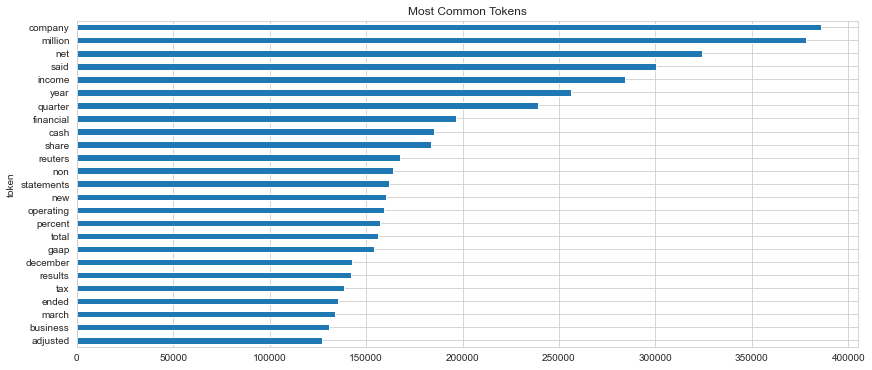

In [21]:
most_common.head(25).set_index('token')['count'].sort_values().plot.barh(title='Most Common Tokens', figsize=(14, 6));

### Inspect Result

In [22]:
clean_articles[:3]

['duluth allete inc',
 'nyse ale today reported earnings share net income million operating revenue billion',
 'results share net income million operating revenue billion']

## Create n-grams

In [23]:
max_length = 3

In [26]:
n_grams = pd.DataFrame()
start = time()
sentences = LineSentence(clean_article_path.as_posix())
for n in range(2, max_length + 1):
    print(n, end=' ')
    if n>2:
        sentences = LineSentence((data_path / f'articles_{n-1}_grams.txt').as_posix())
    phrases = Phrases(sentences, threshold=100, min_count=10)

    s = pd.Series({k.decode('utf-8'): v for k,
                   v in phrases.export_phrases(sentences)}) 
    s = s.to_frame('score').reset_index().rename(
        columns={'index': 'phrase'}).assign(length=n)

    n_grams = pd.concat([n_grams, s])
    grams = Phraser(phrases)
    sentences = grams[sentences]

    with (data_path / f'articles_{n}_grams.txt').open('w') as f:
        for sentence in sentences:
            f.write(' '.join(sentence) + '\n')

n_grams = n_grams.sort_values('score', ascending=False)
n_grams.phrase = n_grams.phrase.str.replace('_', ' ')
n_grams['ngram'] = n_grams.phrase.str.replace(' ', '_')

print('\n\tDuration: ', format_time(time() - start))
print(f'\tngrams: {len(n_grams):,d}\n')
print(n_grams.groupby('length').size())

2 3 
	Duration:  00:09:53
	ngrams: 43,676

length
2    26965
3    16711
dtype: int64


In [27]:
n_grams.groupby('length').apply(lambda x: x.nlargest(10, 'score'))

phrase      score  length  \
length                                                                 
2      17916                        citigate dewe 182,365.18       2   
       23317             hidradenitis suppurativa 182,365.18       2   
       13440           mukhammadsharif mamatkulov 182,365.18       2   
       11037                pracha hariraksapitak 182,365.18       2   
       18997               axalimogene filolisbac 181,951.65       2   
       24230                     navesh chitrakar 181,951.65       2   
       25079                         nidaa tounes 181,951.65       2   
       12947                      koustav samanta 181,951.65       2   
       14914                  shilpa jamkhandikar 181,860.01       2   
       24487              munkhchimeg davaasharav 181,860.01       2   
3      6432                  dana reizniece ozola 189,351.40       3   
       10423       carson elder beerman herberger 189,351.40       3   
       13340   strategist janney montgomery scott 189,351.40       3   
       13581  daniela palmieri jessica fitzgerald 189,351.40       3   
       7974        freshfields bruckhaus deringer 189,351.40       3   
       5610              writing fransiska nangoy 189,351.40       3   
       11953          hgst sandisk tegile upthere 189,351.40       3   
       16481            afinitor afinitor disperz 188,922.03       3   
       4506               spokesman baik tae hyun 188,922.03       3   
       9167         hormone transcon pth transcon 188,922.03       3   

                                            ngram  
length                                             
2      17916                        citigate_dewe  
       23317             hidradenitis_suppurativa  
       13440           mukhammadsharif_mamatkulov  
       11037                pracha_hariraksapitak  
       18997               axalimogene_filolisbac  
       24230                     navesh_chitrakar  
       25079                         nidaa_tounes  
       12947                      koustav_samanta  
       14914                  shilpa_jamkhandikar  
       24487              munkhchimeg_davaasharav  
3      6432                  dana_reizniece_ozola  
       10423       carson_elder_beerman_herberger  
       13340   strategist_janney_montgomery_scott  
       13581  daniela_palmieri_jessica_fitzgerald  
       7974        freshfields_bruckhaus_deringer  
       5610              writing_fransiska_nangoy  
       11953          hgst_sandisk_tegile_upthere  
       16481            afinitor_afinitor_disperz  
       4506               spokesman_baik_tae_hyun  
       9167         hormone_transcon_pth_transcon